# Consumer Complaint Analytics

Consumer complaints in the banking industry provide critical insights for understanding customer satisfaction and regulatory oversight. This research develops an analytical framework to identify high-severity consumer complaints using Natural Language Processing and predictive modeling on 2023 Consumer Financial Protection Bureau (CFPB) data.<br>

Using transformer-based approaches with RoBERTa for sentiment analysis and DistilBERT for emotional classification, I analyzed 487,445 consumer complaint narratives from the 2023 CFPB database. A severity scoring algorithm was developed, balancing keyword-based indicators with sentiment analysis to produce scores ranging from 0 to 1. Through six iterative refinement cycles, the algorithm successfully stratified complaints into distinct severity categories, with high-severity complaints (>0.7) reflecting indicators of fraud, harassment, and financial distress. <br>

Logistic regression and random forest models were tested to predict high-severity complaints from product and issue categories. Models achieved ROC-AUC ~0.61, indicating that product and issue categories alone provide insufficient predictive power. These results suggest that predicting high severity complaints requires the integration of additional variables such as company financial data, complaint timing patterns, or internal company-level data that is not publicly available. 
Notably, sentiment analysis revealed consumer narratives expressing gratitude to the CFPB for complaint resolution, highlighting the value of regulatory transparency and consumer protection services.<br>

A separate notebook includes extensive exploratory data analysis, including in depth analysis of trends withing the banking industry.<br>

*Keywords: Regulatory transparency, Consumer complaints, Severity scoring, Natural Language Processing (NLP), Logistic Regression* 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# for better visuals
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# loading ML libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

# packages needed for batch processing
from tqdm import tqdm
import gc

# loading model packages
from sklearn import linear_model
from sklearn.model_selection import train_test_split, StratifiedKFold    
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve, auc
from mlxtend.feature_selection import SequentialFeatureSelector

# convenience
import warnings
warnings.filterwarnings('ignore')


In [3]:
# full csv file with 1.3M records (not uploaded to GitHub due to size constraints)
consumer = pd.read_csv('complaints-2025-09-03_15_50.csv')

In [7]:
# filter data to only include data where Consumer complaint narrative is not null

consumer_complaint_data = consumer[consumer['Consumer complaint narrative'].notnull()]
consumer_complaint_data.head()


Date received                                            Product  \
0      10/23/23  Credit reporting or other personal consumer re...   
1      07/07/23  Credit reporting, credit repair services, or o...   
2      11/28/23  Credit reporting or other personal consumer re...   
5      10/31/23                                       Student loan   
7      05/10/23  Credit reporting, credit repair services, or o...   

                      Sub-product                                 Issue  \
0                Credit reporting           Improper use of your report   
1                Credit reporting           Improper use of your report   
2                Credit reporting           Improper use of your report   
5  Federal student loan servicing  Dealing with your lender or servicer   
7                Credit reporting  Incorrect information on your report   

                                           Sub-issue  \
0  Credit inquiries on your report that you don't...   
1      Reporting company used your report improperly   
2      Reporting company used your report improperly   
5           Received bad information about your loan   
7                Information belongs to someone else   

                        Consumer complaint narrative  \
0  On XX/XX/XXXX I received notification that the...   
1  15 U.S. Code $ 1681c-2 a consumer reporting ag...   
2  My credit reports are inaccurate. These inaccu...   
5  I cancelled my auto debit along with putting m...   
7  Nine ( 9 ) erroneous and/or fictitious tradeli...   

                             Company public response  \
0  Company has responded to the consumer and the ...   
1                                                NaN   
2  Company has responded to the consumer and the ...   
5                                                NaN   
7  Company believes it acted appropriately as aut...   

                                  Company State ZIP code           Tags  \
0  TRANSUNION INTERMEDIATE HOLDINGS, INC.    MD    21209            NaN   
1                    JPMORGAN CHASE & CO.    CA    95949            NaN   
2     Experian Information Solutions Inc.    GA    XXXXX            NaN   
5                            Nelnet, Inc.    NY    11224            NaN   
7                                  MOHELA    TX    75115  Servicemember   

  Consumer consent provided? Submitted via Date sent to company  \
0           Consent provided           Web             10/23/23   
1           Consent provided           Web             07/07/23   
2           Consent provided           Web             11/28/23   
5           Consent provided           Web             10/31/23   
7           Consent provided           Web             05/10/23   

  Company response to consumer Timely response?  Consumer disputed?  \
0      Closed with explanation              Yes                 NaN   
1      Closed with explanation              Yes                 NaN   
2      Closed with explanation              Yes                 NaN   
5      Closed with explanation              Yes                 NaN   
7      Closed with explanation              Yes                 NaN   

   Complaint ID  
0       7741393  
1       7219680  
2       7907685  
5       7780141  
7       6960785

In [8]:
# checking the results of my filtering
print(f"Original rows {len(consumer)}")
print(f"Filtered rows {len(consumer_complaint_data)}")
print(f"Percent remaining: {len(consumer_complaint_data) / len(consumer):.1%}")

Original rows 1292107
Filtered rows 487445
Percent remaining: 37.7%


### Cleaning up the filtered data

After completing initial exploratory data analysis, the following columns were removed:

**Columns that were dropped from the dataset included:**
- *Submitted via*: column only contains 'Web' values
- *State*: 24.9% of these values from the data were null
- *Company public response*: 43.0% of these values from the filtered data were null
- *Consumer disputed?*: This had a large number of null values and is no longer used by the CFPB
- *Date sent to the company*: already inferred in reponse time
- *Tags*: mostly null
- *Sub-Issue*: the parent issue category appeared more useful
- *Sub-Product*: Not all products have sub products, and this is dependent on the product



In [9]:
# dropping columns that are not useful
not_useful= ['Submitted via', 'State', 'Company public response', 'Sub-product', 'Consumer disputed?', 'Date sent to company',
              'Tags', 'Sub-issue', 'ZIP code']
consumer_complaint_data = consumer_complaint_data.drop(not_useful, axis=1)
consumer_complaint_data.head()

Date received                                            Product  \
0      10/23/23  Credit reporting or other personal consumer re...   
1      07/07/23  Credit reporting, credit repair services, or o...   
2      11/28/23  Credit reporting or other personal consumer re...   
5      10/31/23                                       Student loan   
7      05/10/23  Credit reporting, credit repair services, or o...   

                                  Issue  \
0           Improper use of your report   
1           Improper use of your report   
2           Improper use of your report   
5  Dealing with your lender or servicer   
7  Incorrect information on your report   

                        Consumer complaint narrative  \
0  On XX/XX/XXXX I received notification that the...   
1  15 U.S. Code $ 1681c-2 a consumer reporting ag...   
2  My credit reports are inaccurate. These inaccu...   
5  I cancelled my auto debit along with putting m...   
7  Nine ( 9 ) erroneous and/or fictitious tradeli...   

                                  Company Consumer consent provided?  \
0  TRANSUNION INTERMEDIATE HOLDINGS, INC.           Consent provided   
1                    JPMORGAN CHASE & CO.           Consent provided   
2     Experian Information Solutions Inc.           Consent provided   
5                            Nelnet, Inc.           Consent provided   
7                                  MOHELA           Consent provided   

  Company response to consumer Timely response?  Complaint ID  
0      Closed with explanation              Yes       7741393  
1      Closed with explanation              Yes       7219680  
2      Closed with explanation              Yes       7907685  
5      Closed with explanation              Yes       7780141  
7      Closed with explanation              Yes       6960785

In [10]:
# filling the single missing value
consumer_complaint_data['Company response to consumer'].fillna(
    consumer_complaint_data['Company response to consumer'].mode()[0],  
    inplace=True
)   

In [11]:
# showing the count and percent of nulls, verifying ready for BERT 
missing_values = pd.DataFrame({
    'Data Type': consumer_complaint_data.dtypes,
    'Null Count': consumer_complaint_data.isnull().sum(),
    'Null %': consumer_complaint_data.isnull().mean() * 100
})
missing_values

Data Type  Null Count  Null %
Date received                   object           0     0.0
Product                         object           0     0.0
Issue                           object           0     0.0
Consumer complaint narrative    object           0     0.0
Company                         object           0     0.0
Consumer consent provided?      object           0     0.0
Company response to consumer    object           0     0.0
Timely response?                object           0     0.0
Complaint ID                     int64           0     0.0

# Consumer Complaint Narrative Analysis

My research focuses on predicting complaints related to account management, a crucial component of the customer experience that directly impacts financial institutions' revenue streams. Understanding which issues predict customer complaints about this key service will help expand revenue potential.

Patterns in consumer complaint narratives are particularly valuable for predicting future complaints. In this study, I used RoBERTa to analyze consumer feedback comments, specifically targeting sentiment, severity, and emotion classifications (Athira et al., 2025).

**Initial Prompt**: "Help me use transformer-based approaches like DistilBERT and RoBERTa to classify 'Consumer complaint narrative' by sentiment, severity, and emotion." 

To implement this analysis, I leveraged transformer-based approaches using DistilBERT (Sanh et al., 2019) and RoBERTa (Liu et al., 2019) to classify the 'Consumer complaint narrative' field by sentiment, severity, and emotion. I developed the initial pipeline with Claude's assistance for p ackage installation and starter code configuration. All analytical decisions, including model selection, classification categories, and pipeline refinements, were my own.

During the refinement phase, I iteratively improved the classification pipelines, including adjustments to the severity keyword dictionaries for more accurate categorization. Technical challenges emerged, particularly timeout issues during model execution. Through iterative troubleshooting, I identified the need to explicitly configure GPU processing rather than relying on CPU computation. Additionally, I resolved package conflicts that arose between dependencies, ultimately determining that PyTorch provided the most stable framework for this implementation.

**Sources**<br>

Athira, Adith, M., & Gupta, D. (2025). Effective complaint detection in financial services through complaint, severity, emotion and sentiment analysis. Procedia Computer Science, 258, 2220-2231.

Liu, Y., Ott, M., Goyal, N., Du, J., Joshi, M., Chen, D., Levy, O., Lewis, M., Zettlemoyer, L., & Stoyanov, V. (2019). RoBERTa: A robustly optimized BERT pretraining approach [arXiv preprint arXiv:1907.11692]. arXiv. https://arxiv.org/abs/1907.11692

Sanh, V., Debut, L., Chaumond, J., & Wolf, T. (2019). DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter. arXiv. https://arxiv.org/abs/1910.01108

In [12]:
# previewing the first 25 rows of the Consumer complaint narrative column to see if there are any pattern

consumer_complaint_data['Consumer complaint narrative'].head(10)

0     On XX/XX/XXXX I received notification that the...
1     15 U.S. Code $ 1681c-2 a consumer reporting ag...
2     My credit reports are inaccurate. These inaccu...
5     I cancelled my auto debit along with putting m...
7     Nine ( 9 ) erroneous and/or fictitious tradeli...
10    XX/XX/XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX ...
11    I have paid and contacted the company to get t...
14    On Monday XX/XX/2022 I was trying to refinance...
15    My name is XXXX XXXX XXXX this complaint is no...
16    Ive disputed a bankruptcy multiple times with ...
Name: Consumer complaint narrative, dtype: object

## Consumer Narrative Analysis Pipeline

The BERT pipeline processed consumer narratives using three components: sentiment analysis, emotion analysis, and severity scoring. 

Severity scoring was calculated by combining:
- Keyword frequency counts from defined high-severity and medium-severity word lists
- Sentiment scores (negative, neutral, or positive)

Each component was assigned a weight, with high-severity keywords receiving greater weight than medium-severity keywords, to produce a final severity score.<br>

The keyword lists and scoring weights went through six iterative refinement cycles. For each cycle, I manually reviewed 15 sampled complaints to verify that severity scores aligned with narrative content. High scores (>0.7) reflected severe customer harm such as fraud, harassment, or financial distress, while medium scores (0.3 to 0.7) reflected moderate frustration with service issues, and low scores (<0.3) reflected routine concerns or inquiries. The final keyword lists could be improved through analysis of larger samples or expert review.<br>

Combining the keyword analysis with the sentiment analysis provided a well-balanced approach, where the strengths and weaknesses of each component contributed to a more robust severity score. An indicator column called "high_severity" was created using a severity score threshold of 0.7.


### GPU setup

In [13]:
# Setting up GPU, because CPU takes too long
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")
if device == 0:
    print(f"GPU: {torch.cuda.get_device_name(0)}") # confirm GPU

# sample of data for testing 
sample_size = min(100, len(consumer_complaint_data))
consumer_sample = consumer_complaint_data.head(sample_size).copy()

Using device: GPU
GPU: NVIDIA GeForce RTX 4060


### Sentiment Pipeline

In [ ]:
# sentiment analysis using RoBERTa (PyTorch)
# used RoBERTa to avoid TensorFlow issues
# pretrained model from Hugging Face

# Load sentiment model with safetensors
sentiment_model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment-latest",
    use_safetensors=True
)
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# Create sentiment classifier with GPU
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=sentiment_model,
    tokenizer=sentiment_tokenizer,
    device=device
)

# Function to handle empty or problematic text inputs
def analyze_sentiment(text):
    """Analyze sentiment of text and return label and confidence score"""
    if pd.isna(text) or text == '':
        return 'NEUTRAL', 0.5
    
    try:
        # Truncate text to avoid token limit issues
        text = str(text)[:512]
        result = sentiment_pipeline(text)[0]
        return result['label'], result['score']
    except Exception as e:
        print(f"Error in sentiment analysis: {e}")
        return 'NEUTRAL', 0.5

# Apply sentiment analysis to sample data, make  sure it works
print("Analyzing sentiment...")
sentiment_results = consumer_sample['Consumer complaint narrative'].apply(analyze_sentiment)

# Extract sentiment labels and scores
consumer_sample['sentiment_label'] = [result[0] for result in sentiment_results]
consumer_sample['sentiment_score'] = [result[1] for result in sentiment_results]

# Check distribution
print(f"Sample sentiment distribution:\n{consumer_sample['sentiment_label'].value_counts()}")

### Emotion Pipeline

In [ ]:
# emotion analysis using DistilRoBERTa (PyTorch), lighter and faster version of RoBERTa
# pretrained model from Hugging Face

# Load model with safetensors
emotion_model = AutoModelForSequenceClassification.from_pretrained(
    "j-hartmann/emotion-english-distilroberta-base",
    use_safetensors=True
)

emotion_tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

# Create pipeline with GPU
emotion_pipeline = pipeline(
    "text-classification",
    model=emotion_model,
    tokenizer=emotion_tokenizer,
    device=device  # Use GPU
)

def analyze_emotion(text):
    """Analyze emotion of text and return emotion label and confidence score"""
    if pd.isna(text) or text == '':
        return 'neutral', 0.5
    
    try:
        text = str(text)[:512]
        result = emotion_pipeline(text)[0]
        return result['label'], result['score']
    except Exception as e:
        print(f"Error in emotion analysis: {e}")
        return 'neutral', 0.5

# check emotion analysis with sample 
emotion_results = consumer_sample['Consumer complaint narrative'].apply(analyze_emotion)

# Extract emotion labels and scores
consumer_sample['emotion_label'] = [result[0] for result in emotion_results]
consumer_sample['emotion_score'] = [result[1] for result in emotion_results]

# Check distribution
print(f"Sample emotion distribution:\n{consumer_sample['emotion_label'].value_counts()}")

Device set to use cuda:0


Sample emotion distribution:
emotion_label
neutral     50
anger       30
sadness     12
fear         6
surprise     1
joy          1
Name: count, dtype: int64


### Severity Scoring Pipeline

This combines the sentiment analysis with a keyword scoring algorithm.

In [ ]:
# Claude helped me compile keywords for severity analysis based on research findings (AI use is explicitly defined to fulfull graduate school honor code)
# Claude helped me create a list of packages to compile and gave me starter code that I modified to fit my needs for the RoBERTa pipeline
# I modified the severity lists after reviewing the output, creating an iterative review process for the finalized keywords

def analyze_severity(text, sentiment_label, sentiment_score):
    """
    Analyze severity based on text content and sentiment using weighted components, values from 0 to 1, higher is more severe
    """
    if pd.isna(text) or text == '':
        return 0.0
    
    text_lower = str(text).lower()
    
    # High severity keywords
    high_severity_keywords = [
        'fraud', 'scam', 'steal', 'stolen', 'theft', 'unauthorized', 'illegal',
        'lawsuit', 'sue', 'attorney', 'lawyer', 'court', 'criminal',
        'harassment', 'threat', 'discriminat', 'refuse', 'deny', 'denied',
        'worst', 'terrible', 'horrible', 'awful', 'nightmare', 'disaster',
        'destroy', 'ruin', 'bankrupt', 'poverty', 'homeless', 'evict',
        'emergency', 'urgent', 'crisis', 'desperate', 'help me',
        # Identity theft and account security
        'identity theft', 'ssn', 'social security', 'hacked', 'compromised', 'takeover',
        # Financial harm
        'life savings', 'retirement', 'foreclos', 'forbearance', 'default',
        'collection', 'collections', 'collector',
        # Deceptive practices
        'lie', 'lied', 'mislead', 'deceiv', 'false', 'misrepresent', 'fraudulent', 'evil',
        # Threats to wellbeing
        'suicide', 'health crisis', 'medical emergency',
        # Regulatory escalation
        'attorney general', 'federal trade commission', 'ftc', 'regulator'
    ]

    # Medium severity keywords
    medium_severity_keywords = [
        'error', 'mistake', 'wrong', 'incorrect', 'problem', 'issue',
        'inaccurate', 'inaccuracies', 'inaccuracy',  
        'frustrated', 'angry', 'upset', 'disappointed', 'concern',
        'delay', 'late', 'slow', 'waiting', 'months', 'weeks',
        'fee', 'charge', 'cost', 'expensive', 'overcharge',
        'confusing', 'unclear', 'difficult', 'complicated',
        # Service quality
        'ignore', 'ignored', 'unresponsive', 'no response', 'hang up', 'hung up',
        # Process issues
        'reject', 'rejected', 'cancel', 'cancelled', 'terminated',
        # Communication
        'never called', 'no answer', 'can\'t reach', 'unreachable', 'no contact',
        # Documentation
        'lost', 'missing', 'paperwork', 'documents',
        # Financial institution specific
        'overdraft', 'nsf', 'bounced', 'apr', 'interest rate',
        'credit limit', 'available credit', 'credit report', 'credit score'
    ]
        
    # Count keyword matches
    high_count = sum(1 for keyword in high_severity_keywords if keyword in text_lower)
    medium_count = sum(1 for keyword in medium_severity_keywords if keyword in text_lower)
    
    # Keyword component (0-0.5 range)
    keyword_score = min(0.5, (medium_count * 0.03) + (high_count * 0.12))
    
    # Sentiment component (0-0.5 range)
    sentiment_component = 0
    if sentiment_label == 'negative':
        sentiment_component = sentiment_score * 0.5
    elif sentiment_label == 'positive':
        sentiment_component = -0.1  # Slight reduction for positive sentiment
    
    # Combine components and ensure score stays in valid range (0-1)
    final_score = keyword_score + sentiment_component
    return max(0, min(1.0, final_score))


# Apply severity analysis 
consumer_sample['severity_score'] = consumer_sample.apply(
    lambda row: analyze_severity(
        row['Consumer complaint narrative'], 
        row['sentiment_label'], 
        row['sentiment_score']
    ), axis=1
)

# Display stats, used this to experiment with my severity scoring
severity_stats = consumer_sample['severity_score'].describe().to_frame()
severity_stats.columns = ['Severity Score']
severity_stats.style.format("{:.2f}")

### Sampled results

The sample outputs were used to refine the keyword list and balance the weights on the severity scoring.

In [ ]:
# previewing sample results, this was really crucial to help me test the classification and update the severity keywords
print("Sample classification results:")

# Select a few examples to show
sample_display = consumer_sample[['Consumer complaint narrative', 'sentiment_label', 'sentiment_score', 
                                 'emotion_label', 'emotion_score', 'severity_score']].head(5)

# loop through row to show samples in a vertical list
for idx, row in sample_display.iterrows():
    print(f"\nComplaint {idx + 1}:")
    print(f"Text: {row['Consumer complaint narrative'][:200]}...")
    print(f"Sentiment: {row['sentiment_label']} (confidence: {row['sentiment_score']:.3f})")
    print(f"Emotion: {row['emotion_label']} (confidence: {row['emotion_score']:.3f})")
    print(f"Severity: {row['severity_score']:.3f}")
    print("-" * 50)

Sample classification results:

Complaint 1:
Text: On XX/XX/XXXX I received notification that there had been a hard inquiry from XXXX XXXX XXXX I received an email regarding the denial on XX/XX/XXXX so no account was opened. However I would like to re...
Sentiment: negative (confidence: 0.569)
Emotion: neutral (confidence: 0.359)
Severity: 0.524
--------------------------------------------------

Complaint 2:
Text: 15 U.S. Code $ 1681c-2 a consumer reporting agency shall block the reporting of any information in the file of a consumer that the consumer identifies as information that resulted from an alleged iden...
Sentiment: negative (confidence: 0.783)
Emotion: anger (confidence: 0.807)
Severity: 0.662
--------------------------------------------------

Complaint 3:
Text: My credit reports are inaccurate. These inaccuracies are causing creditors to deny me credit. You have the duty to report accurate information about consumers. Please investigate these accounts and in...
Sentiment: 

### Natural Language Processing

The transformer pipeline consisted of three stages: a sentiment analysis (negative, neutral, positive), an emotion analysis (neutral, anger, sadness, fear, surprise, disgust, joy), and a severity score (values from 0 to 1, 1 being most severe). The three phase consumer complaint NLP pipeline took 1 hour and 48 minutes on the 487,445 consumer complaint narratives. The parquet output is not in my GitHub due to size restraints.<br>

Status updates are included in this pipeline process due to the length of time required. Be prepared for this timing when running the pipeline yourself.

In [ ]:
# making dataframe copy for RoBERTa
# this cell will take almost 2 hours even on GPU
consumer_full = consumer_complaint_data.copy()

# processing the analysis for the full dataset in batches
def process_in_batches(texts, classifier, batch_size=32, desc="Processing"):
    """Process texts in batches with progress bar and memory management"""
    results = []
    texts_list = texts.fillna('').astype(str).tolist()
    
    for i in tqdm(range(0, len(texts_list), batch_size), desc=desc):
        batch = texts_list[i:i + batch_size]
        try:
            batch_results = classifier(batch, truncation=True, max_length=512)
            results.extend(batch_results)
        except Exception as e:
            print(f"\nError at batch {i}: {e}")
            # Add placeholder for failed batch
            results.extend([{'label': 'UNKNOWN', 'score': 0.0}] * len(batch))
        
        # Clear GPU memory every 1000 batches 
        if i % 32000 == 0 and i > 0:
            gc.collect()
            if device == 0:
                torch.cuda.empty_cache()  # Clear GPU cache
    
    return results

# Sentiment analysis
print("\nStep 1/3: Sentiment Analysis")
sentiment_results = process_in_batches(
    consumer_full['Consumer complaint narrative'], 
    sentiment_pipeline,
    batch_size=32,  
    desc="Sentiment"
)
consumer_full['sentiment_label'] = [r['label'] for r in sentiment_results]
consumer_full['sentiment_score'] = [r['score'] for r in sentiment_results]

# Save checkpoint
print("Saving checkpoint after sentiment...")
consumer_full.to_parquet('checkpoint_sentiment.parquet')
del sentiment_results
gc.collect()
if device == 0:
    torch.cuda.empty_cache()

# Emotion analysis
print("\nStep 2/3: Emotion Analysis")
emotion_results = process_in_batches(
    consumer_full['Consumer complaint narrative'], 
    emotion_pipeline,
    batch_size=32,  
    desc="Emotion"
)
consumer_full['emotion_label'] = [r['label'] for r in emotion_results]
consumer_full['emotion_score'] = [r['score'] for r in emotion_results]

# Save checkpoint
print("Saving checkpoint after emotion...")
consumer_full.to_parquet('checkpoint_emotion.parquet')
del emotion_results
gc.collect()
if device == 0:
    torch.cuda.empty_cache()

# Severity analysis (fast)
print("\nStep 3/3: Severity Analysis")
from tqdm import tqdm
tqdm.pandas(desc="Severity")

consumer_full['severity_score'] = consumer_full.progress_apply(
    lambda row: analyze_severity(
        row['Consumer complaint narrative'], 
        row['sentiment_label'], 
        row['sentiment_score']
    ), axis=1
)

# Save final results
print("\nSaving final results...")
consumer_full.to_parquet('consumer_full_analyzed.parquet')

print("\n✓ All done!")
print(f"Processed {len(consumer_full):,} records")
if device == 0:
    print(f"GPU Memory used: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")


Step 1/3: Sentiment Analysis


Sentiment: 100%|██████████| 15233/15233 [1:09:07<00:00,  3.67it/s]



Saving checkpoint after sentiment...

Step 2/3: Emotion Analysis

Step 2/3: Emotion Analysis


Emotion: 100%|██████████| 15233/15233 [39:34<00:00,  6.41it/s] 



Saving checkpoint after emotion...

Step 3/3: Severity Analysis

Step 3/3: Severity Analysis


Severity: 100%|██████████| 487445/487445 [00:34<00:00, 13977.85it/s]




Saving final results...

✓ All done!
Processed 487,445 records
GPU Memory used: 1.67 GB

✓ All done!
Processed 487,445 records
GPU Memory used: 1.67 GB


In [4]:
# load the full analyzed data (not included in GitHub due to size constraints)
consumer_full_bert = pd.read_parquet('consumer_full_analyzed.parquet')

# limiting text width for consumer narrative to 100 characters
pd.set_option('display.max_colwidth', 100)  

consumer_preview = consumer_full_bert.copy()
consumer_preview.head()

Date received  \
0      10/23/23   
1      07/07/23   
2      11/28/23   
5      10/31/23   
7      05/10/23   

                                                                        Product  \
0                           Credit reporting or other personal consumer reports   
1  Credit reporting, credit repair services, or other personal consumer reports   
2                           Credit reporting or other personal consumer reports   
5                                                                  Student loan   
7  Credit reporting, credit repair services, or other personal consumer reports   

                                  Issue  \
0           Improper use of your report   
1           Improper use of your report   
2           Improper use of your report   
5  Dealing with your lender or servicer   
7  Incorrect information on your report   

                                                                          Consumer complaint narrative  \
0  On XX/XX/XXXX I received notification that there had been a hard inquiry from XXXX XXXX XXXX I r...   
1  15 U.S. Code $ 1681c-2 a consumer reporting agency shall block the reporting of any information ...   
2  My credit reports are inaccurate. These inaccuracies are causing creditors to deny me credit. Yo...   
5  I cancelled my auto debit along with putting my account into forbearance on XX/XX/2023. I receiv...   
7  Nine ( 9 ) erroneous and/or fictitious tradelines are being reported by XXXX XXXX as being furni...   

                                  Company Consumer consent provided?  \
0  TRANSUNION INTERMEDIATE HOLDINGS, INC.           Consent provided   
1                    JPMORGAN CHASE & CO.           Consent provided   
2     Experian Information Solutions Inc.           Consent provided   
5                            Nelnet, Inc.           Consent provided   
7                                  MOHELA           Consent provided   

  Company response to consumer Timely response?  Complaint ID sentiment_label  \
0      Closed with explanation              Yes       7741393        negative   
1      Closed with explanation              Yes       7219680        negative   
2      Closed with explanation              Yes       7907685        negative   
5      Closed with explanation              Yes       7780141         neutral   
7      Closed with explanation              Yes       6960785         neutral   

   sentiment_score emotion_label  emotion_score  severity_score  
0         0.568657       neutral       0.358624        0.524328  
1         0.716520         anger       0.896328        0.628260  
2         0.813442       neutral       0.393939        0.616721  
5         0.540882       sadness       0.502510        0.210000  
7         0.587421       neutral       0.427132        0.480000

In [ ]:
# table of sentiment labels with average sentiment score 
sentiment_counts = consumer_full_bert.groupby('sentiment_label').agg(
    Count=('sentiment_label', 'size'),
    Avg_Score=('sentiment_score', 'mean')
)
sentiment_counts['Percentage'] = (sentiment_counts['Count'] / len(consumer_full_bert)) * 100
sentiment_counts = sentiment_counts[['Count', 'Percentage', 'Avg_Score']]
sentiment_counts.style.format({'Percentage': '{:.1f}%', 'Avg_Score': '{:.3f}'}, na_rep='N/A')


In [ ]:
consumer_full_bert['emotion_score'].mean()

np.float64(0.6016916475196338)

In [ ]:
# table of all emotion labels
emotion_counts = consumer_full_bert.groupby('emotion_label').agg(
    Count=('emotion_label', 'size'),
    Avg_Score=('emotion_score', 'mean')
)
emotion_counts['Percentage'] = (emotion_counts['Count'] / len(consumer_full_bert)) * 100
emotion_counts = emotion_counts[['Count', 'Avg_Score', 'Percentage']]
emotion_counts.style.format({'Percentage': '{:.1f}%', 'Avg_Score': '{:.3f}'}, na_rep='N/A')


Emotion had a moderately lower confidence score. One challenge for the emotion score was the direct nature of many of the comments. Further refinement could improve the emotion output. For the purpose of this study, I am focusing on the sentiment and keyword severity counts.

In [ ]:
# severity stats 
severity_stats_full = consumer_full_bert['severity_score'].describe().to_frame()
severity_stats_full.columns = ['Severity Score']
severity_stats_full.style.format("{:.2f}")

In [ ]:
# previewing most severe complaints, I am quite happy with how these turned out
top_severe = consumer_full_bert.sort_values(by='severity_score', ascending=False).head(10)
top_severe[['Consumer complaint narrative', 'severity_score']].style.format({'severity_score': '{:.3f}'}, na_rep='N/A')


In [ ]:
# because pretty plotly graphs make me happy

# Sentiment Distribution
sentiment_counts = consumer_full_bert['sentiment_label'].value_counts()
sentiment_dist = go.Figure()
sentiment_dist.add_trace(
    go.Bar(
        x=sentiment_counts.index,
        y=sentiment_counts.values,
        marker_color='lightblue',
        text=sentiment_counts.values,
        textposition='outside'
    )
)
sentiment_dist.update_layout(
    title='Sentiment Distribution',
    xaxis_title='Sentiment',
    yaxis_title='Count',
    template='plotly_white',
    height=500,
    width=700
)
sentiment_dist.show()

# Emotion Distribution
emotion_counts = consumer_full_bert['emotion_label'].value_counts()
emotion_dist = go.Figure()
emotion_dist.add_trace(
    go.Bar(
        x=emotion_counts.index,
        y=emotion_counts.values,
        marker_color='lightcoral',
        text=emotion_counts.values,
        textposition='outside'
    )
)
emotion_dist.update_layout(
    title='Emotion Distribution',
    xaxis_title='Emotion',
    yaxis_title='Count',
    template='plotly_white',
    height=500,
    width=700
)
emotion_dist.show()

# Severity box plot
consumer_full_bert['severity_category'] = pd.cut(
    consumer_full_bert['severity_score'],
    bins=[0, 0.5, 0.7, 1.0],
    labels=['LOW', 'MEDIUM', 'HIGH']
)

severity_dist = go.Figure()

# colors for each category
colors = {'LOW': 'green', 'MEDIUM': 'orange', 'HIGH': 'red'}

for category in ['LOW', 'MEDIUM', 'HIGH']:
    category_data = consumer_full_bert[consumer_full_bert['severity_category'] == category]['severity_score']
    severity_dist.add_trace(
        go.Box(
            y=category_data,
            name=category,
            marker_color=colors[category]
        )
    )

severity_dist.update_layout(
    title='Severity Score Distribution',
    xaxis_title='Severity Category',
    yaxis_title='Severity Score',
    template='plotly_white',
    height=500,
    width=700,
    showlegend=True
)
severity_dist.show()

# Clean up temporary column
consumer_full_bert.drop('severity_category', axis=1, inplace=True)

In [6]:
# data where the emotion is joy
joy_complaints = consumer_full_bert[consumer_full_bert['sentiment_label'] == 'negative']
# full consumer complaint narrative text for joy complaints
joy_narratives = joy_complaints[['Consumer complaint narrative', 'Issue']]
pd.set_option('display.max_colwidth', None)
joy_narratives.head(20)

Consumer complaint narrative  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              On XX/XX/XXXX I received notification that there had been a hard inquiry from XXXX XXXX XXXX I received an email regarding the denial on XX/XX/XXXX so no account was opened. However I would like to request that the inquiry from XX/XX/XXXX be removed as I did not make this request. I have contacted the financial institution to advise this was a fraudulent request on XX/XX/XXXX.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     15 U.S. Code $ 1681c-2 a consumer reporting agency shall block the reporting of any information in the file of a consumer that the consumer identifies as information that resulted from an alleged identity theft, not later than 4 business days after the date of receipt. It has been 30 days and you are in VIOLATION of this law because I am a victim of identity theft! Please delete these items IMMEDIATELY!\n\nThese accounts should not be furnished on my consumer reports as they are in VIOLATION!!!\n\nUnder, 15 U.S. Code 1681b- Permissible purposes of consumer reports ( a ) IN GENERAL subject to subsection ( C ) any consumer reporting agency may furnish a consumer report under the following circumstances and no other : ( 2 ) in accordance with the WRITTEN INSTRUCTION of the consumer to whom it relates. I NEVER gave any consumer reporting agency WRITTEN CONSENT to report anything on my consumer report which violates my rights as a federal protected consumer. NO CONSENT IS IDENTITY THEFT. As a consumer, I am demanding the deletion of the accounts listed IMMEDIATELY!   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

# Predicting high severity consumer complaints 

## Further data processing
After completing the BERT analysis, an indicator column for 'high_severity' was created, using a severity score threshold of .7 or higher (this cut off represents the top quartile). Because 'high_severity' is extrapolated from the the consumer complaint narrative and corresponding BERT analysis columns, the complaint narrative and BERT columns were removed from the data in preparation for modeling.

Additional columns were identified for removal, including:

- *Complaint ID*: This unique identifier value is not useful for modeling
- *Timely response?*: This can not be known before a consumer complaint is registered
- *Response Time*: Like timely response, this is not a useful predictive variable 

In [ ]:
# making ML data
consumer_ML = consumer_full_bert.copy()

# indicator column for consent, was not a good predictor
consumer_ML['Consent'] = consumer_ML['Consumer consent provided?'].map(
    {"Consent provided": 1}
).fillna(0).astype(int)
consumer_ML.head()

# indicator column for high severity (1 = TRUE)
consumer_ML['high_severity'] = (consumer_ML['severity_score'] >= 0.7).astype(int)

## Data Cleaning

The Consumer Financial Protection Bureau has cleaned up some of their categorization in recent years. Data cleaning was completed to match the current product classification. Additionally, improvements in issue type were completed for the purpose of this analysis. Functions were created for both the product and issue columns to standardize values.<br>
The product cleaning function reduced the unique values from 14 to 10. The issue cleaning function reduced the unique values from 91 to 48.

In [10]:
# cleaning out columns that wouldn't be available at the time of prediction, or not useful for ML
data_cleaning_columns = ['Complaint ID', 'Timely response?', 'Consumer complaint narrative', 'Company response to consumer',
                         'Date received', 'Consumer consent provided?', 'Consent', #converted to indicator column wasn't useful
                         'sentiment_label', 'sentiment_score', 'emotion_label','emotion_score', 'severity_score'] #bert analysis
consumer_ML.drop(data_cleaning_columns, axis=1, inplace=True)
consumer_ML.head()

Product  \
0                           Credit reporting or other personal consumer reports   
1  Credit reporting, credit repair services, or other personal consumer reports   
2                           Credit reporting or other personal consumer reports   
5                                                                  Student loan   
7  Credit reporting, credit repair services, or other personal consumer reports   

                                  Issue  \
0           Improper use of your report   
1           Improper use of your report   
2           Improper use of your report   
5  Dealing with your lender or servicer   
7  Incorrect information on your report   

                                  Company  high_severity  
0  TRANSUNION INTERMEDIATE HOLDINGS, INC.              0  
1                    JPMORGAN CHASE & CO.              0  
2     Experian Information Solutions Inc.              0  
5                            Nelnet, Inc.              0  
7                                  MOHELA              0

In [12]:
# cleaning values to match current product groups
def standardize_product(product):
    product_str = str(product).lower()
    if 'credit reporting' in product_str:
        return 'Credit reporting'
    elif 'payday loan, title loan, personal loan, or advance loan' in product_str:
        # new product category is Payday/title/personal loan - kept commas for consistency with this data
        return 'Payday loan, title loan, or personal loan'
    elif 'credit card or prepaid card' in product_str or 'prepaid card' in product_str:
        return 'Credit card'
    return product

# cleaning issue types to simplify and improve predictive power
# I created the beginning function, then had Claude expand the elif statements based on my returned unique values for issue
def standardize_issue(issue):
    issue_str = str(issue).lower()
    
    # Existing mappings
    if 'fees' in issue_str:
        return 'Unexpected or other fees'
    elif 'getting' in issue_str:
        return 'Opening an account'
    elif 'struggling' in issue_str:
        return 'Struggling to pay'
    
    # Investigation problems
    elif "investigation into an existing" in issue_str:
        return "Problem with a company's investigation into an existing problem"
    
    # Advertising
    elif issue_str in ['advertising and marketing, including promotional offers', 
                       'confusing or misleading advertising or marketing',
                       'advertising']:
        return 'Confusing or misleading advertising or marketing'
    
    # Identity Theft/Monitoring Services
    elif issue_str in ['identity theft protection or other monitoring services',
                       'credit monitoring or identity theft protection services']:
        return 'Identity and monitoring services'
    
    # Unauthorized Transactions
    elif issue_str in ['unauthorized transactions or other transaction problem',
                       'unauthorized withdrawals or charges']:
        return 'Unauthorized transactions'
    
    # Lender Communication
    elif issue_str in ['dealing with your lender or servicer',
                       "can't contact lender or servicer"]:
        return 'Communication with lender or service provider'
    
    # Mobile Wallet
    elif issue_str == 'trouble accessing funds in your mobile or digital wallet':
        return 'Other transaction problem'
    elif issue_str == 'managing, opening, or closing your mobile wallet account':
        return 'Managing an account'
    
    # Lost/Stolen Payment Instruments
    elif issue_str in ['lost or stolen money order', 'lost or stolen check']:
        return 'Lost or stolen funds'
    
    # End of Loan Issues
    elif issue_str in ['problems at the end of the loan or lease',
                       'problem with the payoff process at the end of the loan']:
        return 'Problems at the end of loan or lease'
    
    # Account/Loan Management
    elif issue_str == 'managing the loan or lease':
        return 'Managing an account'
    
    # Account closing
    elif issue_str == 'closing your account':
        return 'Closing an account'
    
    # Card usage problems
    elif issue_str == 'trouble using the card':
        return 'Trouble using your card'
    
    return issue

In [ ]:
# looking at count of high severity vs low severity complaints by month
consumer_month = consumer_full_bert.copy()

# indicator column for high severity (1 = TRUE)
consumer_month['high_severity'] = (consumer_month['severity_score'] >= 0.7).astype(int)

consumer_month['Product'] = consumer_month['Product'].apply(standardize_product)

consumer_month['Date received'] = pd.to_datetime(consumer_month['Date received'], errors='coerce')
consumer_month['Month'] = consumer_month['Date received'].dt.to_period('M').astype(str)

# Group by month and severity
severity_monthly = consumer_month.groupby(['Month', 'high_severity']).size().reset_index(name='Count')
severity_monthly['Severity'] = severity_monthly['high_severity'].map({1: 'High', 0: 'Low'})

month_viz = px.bar(severity_monthly, x='Month', y='Count', color='Severity', barmode='group',
             title='Monthly Complaint Severity Distribution',   
             labels={'Count': 'Number of Complaints', 'Month': 'Month'},
             color_discrete_map={'High': '#cc5555', 'Low': '#5588cc'})  # Less saturated colors

month_viz.update_layout(
    xaxis_tickangle=-45, 
    template='plotly_white', 
    height=600, 
    width=1000,
    title={
        'text': 'Monthly Complaint Severity Distribution',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    legend=dict(
        orientation="h",
        yanchor="top",
        y=0.95,
        xanchor="center",
        x=0.5
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=sorted(severity_monthly['Month'].unique()),
        ticktext=sorted(severity_monthly['Month'].unique())
    )
)

month_viz.show()


In [ ]:
# Filtering severity_monthly to only include high severity complaints
high_severity_monthly = consumer_month[consumer_month['high_severity'] == 1].groupby(['Month', 'Product']).size().reset_index(name='Count')

# total complaints per product for ordering
product_order = high_severity_monthly.groupby('Product')['Count'].sum().sort_values(ascending=False).index.tolist()

# Extract month names for tick labels
month_names = [pd.to_datetime(m).strftime('%b') for m in high_severity_monthly['Month'].unique()]
month_vals = high_severity_monthly['Month'].unique()

product_viz_high = px.line(
    high_severity_monthly,
    x='Month',
    y='Count',
    color='Product',
    category_orders={'Product': product_order, 'Month': list(month_vals)},
    title='Monthly High Severity Complaints by Product (2023)',
    labels={'Count': 'Number of High Severity Complaints', 'Month': 'Month'},
    color_discrete_sequence=px.colors.qualitative.Dark24,
    height=900
)

product_viz_high.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=list(month_vals),
        ticktext=month_names
    )
)

product_viz_high

In [52]:
consumer_ML['Product'].unique()

array(['Credit reporting or other personal consumer reports',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Student loan', 'Debt collection', 'Credit card',
       'Payday loan, title loan, or personal loan',
       'Checking or savings account',
       'Money transfer, virtual currency, or money service', 'Mortgage',
       'Prepaid card', 'Vehicle loan or lease',
       'Credit card or prepaid card',
       'Payday loan, title loan, personal loan, or advance loan',
       'Debt or credit management'], dtype=object)

In [9]:
consumer_ML_clean = consumer_ML.copy()
consumer_ML_clean['Product'] = consumer_ML_clean['Product'].apply(standardize_product)
consumer_ML_clean['Issue'] = consumer_ML_clean['Issue'].apply(standardize_issue)
consumer_ML_clean.head(10)

Product  \
0   Credit reporting   
1   Credit reporting   
2   Credit reporting   
5       Student loan   
7   Credit reporting   
10  Credit reporting   
11  Credit reporting   
14      Student loan   
15  Credit reporting   
16  Credit reporting   

                                                              Issue  \
0                                       Improper use of your report   
1                                       Improper use of your report   
2                                       Improper use of your report   
5                     Communication with lender or service provider   
7                              Incorrect information on your report   
10  Problem with a company's investigation into an existing problem   
11                             Incorrect information on your report   
14                             Incorrect information on your report   
15                                      Improper use of your report   
16  Problem with a company's investigation into an existing problem   

                                    Company  high_severity  
0    TRANSUNION INTERMEDIATE HOLDINGS, INC.              0  
1                      JPMORGAN CHASE & CO.              0  
2       Experian Information Solutions Inc.              0  
5                              Nelnet, Inc.              0  
7                                    MOHELA              0  
10                            EQUIFAX, INC.              0  
11      Experian Information Solutions Inc.              0  
14  College Ave Student Loan Servicing, LLC              0  
15                            EQUIFAX, INC.              0  
16      Experian Information Solutions Inc.              0

In [55]:
# checking how many unique values I had
len(consumer_ML_clean['Product'].unique())
#len(consumer_ML['Product'].unique())

10

In [ ]:
# preparing data for modeling
consumer_ML_encoded = pd.get_dummies(consumer_ML, columns=['Product', 'Issue', 'Company'], dtype=int, drop_first=True)
consumer_ML_encoded.head()

# Selecting the predictive model

The goal will be to predict whether a consumer complaint will be severe. Since the response (high_severity = True/False) is binary, I plan to use logistic regression but am also testing random forest due to the high number of variations within the categorical predictors. <br>

I was hesitant to use company, as this variable seemed highly likely to create overfitting. Large companies tend to have a large number of consumer complaints; any variation within company predictions is likely correlated with the scale of these institutions rather than meaningful differences in how complaints are handled. When creating my models, including 'Company' as a predictive variable provided no meaningful improvement to the results and decreased the generalizability of the model. I do plan to analyze trends within banking using the final model as an interpretive tool.

# Logistic regression

Because there were no trends apparent with the time analysis, the logistic regression model will include product, and issue. I created a sample batch for my GridSearch analysis. Using the full dataset to tune hyperparameters was not practical (computationally intensive on nearly a half million rows of data).

In [57]:
# splitting data into X and y
X = consumer_ML_encoded.drop('high_severity', axis=1)
y = consumer_ML_encoded['high_severity']
X.shape, y.shape

((487445, 2971), (487445,))

In [58]:
# splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# creating a sample for GridSearch, because running this on the full dataset was a poor choice
sample_size = 5000  
sample_indices = np.random.choice(len(X_train), size=min(sample_size, len(X_train)), replace=False)
X_train_sample = X_train.iloc[sample_indices]
y_train_sample = y_train.iloc[sample_indices]

print(f"Using sample of {len(X_train_sample):,} records for hyperparameter tuning")
print(f"Sample class distribution: {y_train_sample.value_counts(normalize=True).round(3).to_dict()}")

Using sample of 5,000 records for hyperparameter tuning
Sample class distribution: {0: 0.778, 1: 0.222}


In [ ]:
# working on the logistic regression model first
# hyperparameters
lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear'],  
    'max_iter': [1000],  
    'class_weight': ['balanced'] 
}

# GridSearchCV 
lr_grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid=lr_param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=1,  
    verbose=1
)

lr_grid_search.fit(X_train, y_train)

print("\nOptimization Results:")
print("Best Parameters:", lr_grid_search.best_params_)
print("Best Cross-validation ROC-AUC:", lr_grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Optimization Results:
Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-validation ROC-AUC: 0.6188707152806

Optimization Results:
Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-validation ROC-AUC: 0.6188707152806


In [59]:
# creating the logistic regression model with recommended hyper parameters
model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0, penalty='l2', solver='liblinear')
model.fit(X_train, y_train)
# make predictions
y_pred = model.predict(X_test)

In [60]:
# evaluate the logistic regression model
print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

# Added ROC-AUC 
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Logistic Regression Performance:
Accuracy: 0.6142
Precision: 0.3082
Recall: 0.5684
F1-Score: 0.3997
ROC-AUC: 0.6189

Confusion Matrix:
[[47361 28102]
 [ 9507 12519]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72     75463
           1       0.31      0.57      0.40     22026

    accuracy                           0.61     97489
   macro avg       0.57      0.60      0.56     97489
weighted avg       0.71      0.61      0.64     97489

ROC-AUC: 0.6189

Confusion Matrix:
[[47361 28102]
 [ 9507 12519]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72     75463
           1       0.31      0.57      0.40     22026

    accuracy                           0.61     97489
   macro avg       0.57      0.60      0.56     97489
weighted avg       0.71      0.61      0.64     97489



In [61]:
# Get feature coefficients from the logistic regression model, using absolute value to more easily pull the biggest influencers
# I am highly suspicious that the company features are more indicative of the sizes of these organizations than the actual severity of the complaints
feature_coefficientsc = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

display(feature_coefficientsc[['feature', 'coefficient']].head(10).style.format({
    'coefficient': '{:+.4f}'
}))

## Logistic Regression without Company



In [62]:
# Creating a second dataset without company variables for comparison
consumer_ML_noc = consumer_ML.copy()
consumer_ML_noc = consumer_ML.copy()
consumer_ML_noc.drop('Company', axis=1, inplace=True)
consumer_ML_noc = pd.get_dummies(consumer_ML_noc, columns=['Product', 'Issue'], dtype=int, drop_first=True)
consumer_ML_noc.head()

high_severity  Product_Credit card  Product_Credit card or prepaid card  \
0              0                    0                                    0   
1              0                    0                                    0   
2              0                    0                                    0   
5              0                    0                                    0   
7              0                    0                                    0   

   Product_Credit reporting or other personal consumer reports  \
0                                                            1   
1                                                            0   
2                                                            1   
5                                                            0   
7                                                            0   

   Product_Credit reporting, credit repair services, or other personal consumer reports  \
0                                                                                     0   
1                                                                                     1   
2                                                                                     0   
5                                                                                     0   
7                                                                                     1   

   Product_Debt collection  Product_Debt or credit management  \
0                        0                                  0   
1                        0                                  0   
2                        0                                  0   
5                        0                                  0   
7                        0                                  0   

   Product_Money transfer, virtual currency, or money service  \
0                                                           0   
1                                                           0   
2                                                           0   
5                                                           0   
7                                                           0   

   Product_Mortgage  Product_Payday loan, title loan, or personal loan  ...  \
0                 0                                                  0  ...   
1                 0                                                  0  ...   
2                 0                                                  0  ...   
5                 0                                                  0  ...   
7                 0                                                  0  ...   

   Issue_Unauthorized transactions or other transaction problem  \
0                                                             0   
1                                                             0   
2                                                             0   
5                                                             0   
7                                                             0   

   Issue_Unauthorized withdrawals or charges  Issue_Unexpected fees  \
0                                          0                      0   
1                                          0                      0   
2                                          0                      0   
5                                          0                      0   
7                                          0                      0   

   Issue_Unexpected or other fees  \
0                               0   
1                               0   
2                               0   
5                               0   
7                               0   

   Issue_Vehicle was damaged or destroyed the vehicle  \
0                                                   0   
1                                                   0   
2                                                   0   
5                                                   

In [63]:
# Split data
X_nc = consumer_ML_noc.drop('high_severity', axis=1)
y_nc = consumer_ML_noc['high_severity']

X_train_nc, X_test_nc, y_train_nc, y_test_nc = train_test_split(
    X_nc, y_nc, test_size=0.2, random_state=42, stratify=y_nc
)

print("Training set shape (no company):", X_train_nc.shape)
print("Test set shape (no company):", X_test_nc.shape)

Training set shape (no company): (389956, 103)
Test set shape (no company): (97489, 103)


In [ ]:
# confirming the same hyperparameters work well without company
# hyperparameters
lr2_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga'],  
    'max_iter': [1000],  
    'class_weight': ['balanced'] 
}

# GridSearchCV 
lr2_grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid=lr2_param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=1,  
    verbose=1
)

lr2_grid_search.fit(X_train_nc, y_train_nc)

print("\nOptimization Results for Logistic Regression without company:")
print("Best Parameters:", lr2_grid_search.best_params_)
print("Best Cross-validation ROC-AUC:", lr2_grid_search.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Optimization Results for Logistic Regression without company:
Best Parameters: {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-validation ROC-AUC: 0.6138638867268448

Optimization Results for Logistic Regression without company:
Best Parameters: {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-validation ROC-AUC: 0.6138638867268448


In [64]:
# logistic regression model without company variables
model_no_company = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0, penalty='l2', solver='liblinear', random_state=42)
model_no_company.fit(X_train_nc, y_train_nc)

# Make predictions
y_pred_nc = model_no_company.predict(X_test_nc)

In [65]:
# evaluate the logistic regression model without company variables
print("\nLogistic Regression (no company) Performance:")
print(f"Accuracy: {accuracy_score(y_test_nc, y_pred_nc):.4f}")
print(f"Precision: {precision_score(y_test_nc, y_pred_nc):.4f}")
print(f"Recall: {recall_score(y_test_nc, y_pred_nc):.4f}")
print(f"F1-Score: {f1_score(y_test_nc, y_pred_nc):.4f}")

# Added ROC-AUC 
y_pred_proba_nc = model_no_company.predict_proba(X_test_nc)[:, 1]  
print(f"ROC-AUC: {roc_auc_score(y_test_nc, y_pred_proba_nc):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_nc, y_pred_nc))

print("\nClassification Report:")
print(classification_report(y_test_nc, y_pred_nc))



Logistic Regression (no company) Performance:
Accuracy: 0.6157
Precision: 0.3072
Recall: 0.5582
F1-Score: 0.3963
ROC-AUC: 0.6152

Confusion Matrix:
[[47732 27731]
 [ 9732 12294]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72     75463
           1       0.31      0.56      0.40     22026

    accuracy                           0.62     97489
   macro avg       0.57      0.60      0.56     97489
weighted avg       0.71      0.62      0.65     97489



In [66]:
# Get feature coefficients from the logistic regression model, using absolute value to more easily pull the biggest influencers
feature_coefficients = pd.DataFrame({
    'feature': X_train_nc.columns,
    'coefficient': model_no_company.coef_[0],
    'abs_coefficient': np.abs(model_no_company.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

display(feature_coefficients[['feature', 'coefficient']].head(10).style.format({
    'coefficient': '{:+.4f}'
}))

### LASSO to shrink coefficients

After doing some modeling, I could see the correlated product and issue features competing with each other. For example, the two most influential coefficients weere "Product_credit card" and "Issue_Getting a credit card". I decided to use LASSO regression to decide which coefficients could be shrinked to simplify the model.<br>

After completing the LASSO, the resulting coefficients were added to a list. I refined this list further, commenting out similar issues or products. For example, there was an indicator column for 'Product_Credit card', 'Product_Credit card or prepaid card' and 'Product_Prepaid card'. I selected to comment out 'Product_Credit card or prepaid card' to remove this from the list.

In [ ]:
# setting up the LASSO to identify the best features

sfs = SequentialFeatureSelector(
    model_no_company ,
    k_features="best",        
    forward=True,
    floating=False,
    scoring='roc_auc',
    cv=StratifiedKFold(3)
)
    
sfs = sfs.fit(X_nc, y_nc)

logreg_l1 = LogisticRegressionCV(
    penalty='l1',
    solver='liblinear',   
    Cs=10,                
    cv=5,
    scoring='roc_auc',
    max_iter=1000
)

logreg_l1.fit(X_nc, y_nc)

# see recommended features 
coef = logreg_l1.coef_[0]
selected = X_nc.columns[coef != 0]
print("Selected features:", selected)

In [67]:
# list of response and all variables to use from the list that removed company
# looked through the list and commented out highly correlated variables
lasso_results =  ['high_severity','Product_Credit card', #'Product_Credit card or prepaid card' 
       'Product_Credit reporting or other personal consumer reports',
       #'Product_Credit reporting, credit repair services, or other personal consumer reports',
       'Product_Mortgage', 'Product_Payday loan, title loan, or personal loan',
       #'Product_Payday loan, title loan, personal loan, or advance loan',
       'Product_Prepaid card',
       'Issue_Advertising and marketing, including promotional offers',
       'Issue_Applying for a mortgage or refinancing an existing mortgage',
       'Issue_Attempts to collect debt not owed',
       "Issue_Can't stop withdrawals from your bank account",
       'Issue_Charged fees or interest you didn\'t expect',
       'Issue_Charged upfront or unexpected fees', 'Issue_Closing an account',
       'Issue_Closing on a mortgage', 'Issue_Closing your account',
       'Issue_Communication tactics',
       'Issue_Confusing or misleading advertising or marketing',
       'Issue_Confusing or missing disclosures', 'Issue_Credit limit changed',
       'Issue_Credit monitoring or identity theft protection services',
       'Issue_Dealing with your lender or servicer',
       "Issue_Didn't provide services promised",
       'Issue_Electronic communications', 'Issue_Excessive fees',
       'Issue_False statements or representation', 'Issue_Fees or interest',
       'Issue_Fraud or scam', 'Issue_Getting a line of credit',
       'Issue_Getting a loan', 'Issue_Getting a loan or lease',
       #'Issue_Getting the loan'
       'Issue_Identity theft protection or other monitoring services',
       'Issue_Improper use of your report', 'Issue_Incorrect exchange rate',
       'Issue_Incorrect information on your report',
       "Issue_Loan payment wasn't credited to your account",
       'Issue_Lost or stolen check', 'Issue_Lost or stolen money order',
       'Issue_Managing an account', 'Issue_Managing the loan or lease',
       'Issue_Managing, opening, or closing your mobile wallet account',
       'Issue_Money was not available when promised',
       'Issue_Money was taken from your bank account on the wrong day or for the wrong amount',
       'Issue_Opening an account', 'Issue_Other features, terms, or problems',
       'Issue_Other service problem', 'Issue_Other transaction problem',
       'Issue_Overdraft, savings, or rewards features',
       'Issue_Problem adding money',
       'Issue_Problem caused by your funds being low',
       'Issue_Problem getting a card or closing an account',
       'Issue_Problem when making payments',
       #"Issue_Problem with a company's investigation into an existing issue",
       "Issue_Problem with a company's investigation into an existing problem",
       #"Issue_Problem with a credit reporting company's investigation into an existing problem",
       "Issue_Problem with a lender or other company charging your account",
       'Issue_Problem with a purchase or transfer',
       'Issue_Problem with a purchase shown on your statement',
       'Issue_Problem with additional add-on products or services',
       'Issue_Problem with customer service',
       'Issue_Problem with fraud alerts or security freezes',
       'Issue_Problem with the payoff process at the end of the loan',
       'Issue_Problems at the end of the loan or lease',
       "Issue_Received a loan you didn't apply for", 'Issue_Repossession',
       'Issue_Struggling to pay mortgage', 'Issue_Struggling to pay your bill',
       'Issue_Struggling to pay your loan',
       'Issue_Struggling to repay your loan',
       'Issue_Threatened to contact someone or share information improperly',
       'Issue_Took or threatened to take negative or legal action',
       'Issue_Trouble accessing funds in your mobile or digital wallet',
       'Issue_Trouble during payment process', #'Issue_Trouble using the card',
       'Issue_Trouble using your card',
       'Issue_Unable to get your credit report or credit score',
       'Issue_Unauthorized transactions or other transaction problem',
       'Issue_Unauthorized withdrawals or charges',
       'Issue_Unexpected or other fees',
       'Issue_Vehicle was repossessed or sold the vehicle',
       "Issue_Was approved for a loan, but didn't receive the money",
       'Issue_Written notification about debt',
       'Issue_Wrong amount charged or received']

In [ ]:
# Filtering consumer_ML_noc to only include columns that exist in both the dataframe and lasso_results list
available_columns = [col for col in lasso_results if col in consumer_ML_noc.columns]
print(f"Available columns from lasso_results: {len(available_columns)} out of {len(lasso_results)}")

# filtered dataframe
consumer_lasso = consumer_ML_noc[available_columns].copy()

print(f"Original consumer_ML_noc shape: {consumer_ML_noc.shape}")
print(f"Filtered consumer_lasso shape: {consumer_lasso.shape}")

consumer_lasso.head()


Available columns from lasso_results: 79 out of 79
Original consumer_ML_noc shape: (487445, 104)
Filtered consumer_lasso shape: (487445, 79)


high_severity  Product_Credit card  \
0              0                    0   
1              0                    0   
2              0                    0   
5              0                    0   
7              0                    0   

   Product_Credit reporting or other personal consumer reports  \
0                                                            1   
1                                                            0   
2                                                            1   
5                                                            0   
7                                                            0   

   Product_Mortgage  Product_Payday loan, title loan, or personal loan  \
0                 0                                                  0   
1                 0                                                  0   
2                 0                                                  0   
5                 0                                                  0   
7                 0                                                  0   

   Product_Prepaid card  \
0                     0   
1                     0   
2                     0   
5                     0   
7                     0   

   Issue_Advertising and marketing, including promotional offers  \
0                                                              0   
1                                                              0   
2                                                              0   
5                                                              0   
7                                                              0   

   Issue_Applying for a mortgage or refinancing an existing mortgage  \
0                                                                  0   
1                                                                  0   
2                                                                  0   
5                                                                  0   
7                                                                  0   

   Issue_Attempts to collect debt not owed  \
0                                        0   
1                                        0   
2                                        0   
5                                        0   
7                                        0   

   Issue_Can't stop withdrawals from your bank account  ...  \
0                                                    0  ...   
1                                                    0  ...   
2                                                    0  ...   
5                                                    0  ...   
7                                                    0  ...   

   Issue_Trouble during payment process  Issue_Trouble using your card  \
0                                     0                              0   
1                                     0                              0   
2                                     0                              0   
5                                     0                              0   
7                                     0                              0   

   Issue_Unable to get your credit report or credit score  \
0                                                       0   
1                                                       0   
2                                                       0   
5                                                       0   
7                                                       0   

   Issue_Unauthorized transactions or other transaction problem  \
0                                                             0   
1                                                             0   
2                                                             0   
5                                                             0   
7                                                             0   

   Issue_Unauthorized withdrawals or c

In [69]:
# Split data
X_l = consumer_lasso.drop('high_severity', axis=1)
y_l = consumer_lasso['high_severity']

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    X_l, y_l, test_size=0.2, random_state=42, stratify=y_l
)

print("Training set shape (LASSO):", X_train_l.shape)
print("Test set shape (LASSO):", X_test_l.shape)

Training set shape (LASSO): (389956, 78)
Test set shape (LASSO): (97489, 78)


In [70]:
# logistic regression model with LASSO variables
model_lasso = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0, penalty='l2', solver='liblinear', random_state=42)
model_lasso.fit(X_train_l, y_train_l)

# Make predictions
y_pred_l = model_lasso.predict(X_test_l)

In [71]:
# evaluate the LASSO logistic regression model w
print("\nLogistic Regression w/ Lasso variables Performance:")
print(f"Accuracy: {accuracy_score(y_test_l, y_pred_l):.4f}")
print(f"Precision: {precision_score(y_test_l, y_pred_l):.4f}")
print(f"Recall: {recall_score(y_test_l, y_pred_l):.4f}")
print(f"F1-Score: {f1_score(y_test_l, y_pred_l):.4f}")

# Added ROC-AUC 
y_pred_proba_l = model_lasso.predict_proba(X_test_l)[:, 1]  
print(f"ROC-AUC: {roc_auc_score(y_test_l, y_pred_proba_l):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_l, y_pred_l))

print("\nClassification Report:")
print(classification_report(y_test_l, y_pred_l))


Logistic Regression w/ Lasso variables Performance:
Accuracy: 0.6181
Precision: 0.3067
Recall: 0.5476
F1-Score: 0.3932
ROC-AUC: 0.6103

Confusion Matrix:
[[48200 27263]
 [ 9964 12062]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.64      0.72     75463
           1       0.31      0.55      0.39     22026

    accuracy                           0.62     97489
   macro avg       0.57      0.59      0.56     97489
weighted avg       0.71      0.62      0.65     97489



In [ ]:
# feature coefficients from the logistic regression model, using absolute value to more easily pull the biggest influencers
feature_coefficients_lasso = pd.DataFrame({
    'feature': X_train_l.columns,
    'coefficient': model_lasso.coef_[0],
    'abs_coefficient': np.abs(model_lasso.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

display(feature_coefficients_lasso[['feature', 'coefficient']].head(10).style.format({
    'coefficient': '{:+.4f}'
}))

### Logistic Regression with cleaned product and issue types

After spending more time cleaning the product and issue types and additional logistic regression model was created.

In [10]:
# Creating a second dataset without company variables for comparison
consumer_ML_final = consumer_ML_clean.copy()
consumer_ML_final.drop(['Company'], axis=1, inplace=True)
consumer_ML_final = pd.get_dummies(consumer_ML_final, columns=['Product', 'Issue'], dtype=int, drop_first=True)
consumer_ML_final.head()

high_severity  Product_Credit card  Product_Credit reporting  \
0              0                    0                         1   
1              0                    0                         1   
2              0                    0                         1   
5              0                    0                         0   
7              0                    0                         1   

   Product_Debt collection  Product_Debt or credit management  \
0                        0                                  0   
1                        0                                  0   
2                        0                                  0   
5                        0                                  0   
7                        0                                  0   

   Product_Money transfer, virtual currency, or money service  \
0                                                           0   
1                                                           0   
2                                                           0   
5                                                           0   
7                                                           0   

   Product_Mortgage  Product_Payday loan, title loan, or personal loan  \
0                 0                                                  0   
1                 0                                                  0   
2                 0                                                  0   
5                 0                                                  0   
7                 0                                                  0   

   Product_Student loan  Product_Vehicle loan or lease  ...  \
0                     0                              0  ...   
1                     0                              0  ...   
2                     0                              0  ...   
5                     1                              0  ...   
7                     0                              0  ...   

   Issue_Trouble using your card  \
0                              0   
1                              0   
2                              0   
5                              0   
7                              0   

   Issue_Unable to get your credit report or credit score  \
0                                                       0   
1                                                       0   
2                                                       0   
5                                                       0   
7                                                       0   

   Issue_Unauthorized transactions  Issue_Unexpected or other fees  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
5                                0                               0   
7                                0                               0   

   Issue_Vehicle was damaged or destroyed the vehicle  \
0                                                   0   
1                                                   0   
2                                                   0   
5                                                   0   
7                                                   0   

   Issue_Vehicle was repossessed or sold the vehicle  \
0                                                  0   
1                                                  0   
2                                                  0   
5                                                  0   
7                                                  0   

   Issue_Was approved for a loan, but didn't receive money  \
0                                                        0   
1                                                        0   
2                                                        0   
5                                                        0   

In [11]:
# Split data
X_f = consumer_ML_final.drop('high_severity', axis=1)
y_f = consumer_ML_final['high_severity']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_f, y_f, test_size=0.2, random_state=42, stratify=y_f
)

print("Training set shape:", X_train_f.shape)
print("Test set shape:", X_test_f.shape)

Training set shape: (389956, 71)
Test set shape: (97489, 71)


In [12]:
# logistic regression model with cleaned product and issue
model_final = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0, penalty='l2', solver='liblinear', random_state=42)
model_final.fit(X_train_f, y_train_f)

# Make predictions
y_pred_f = model_final.predict(X_test_f)

In [42]:
# evaluate the cleaned logistic model
print("\nLogistic Regression w/ cleaned variables:")
print(f"Accuracy: {accuracy_score(y_test_f, y_pred_f):.4f}")
print(f"Precision: {precision_score(y_test_f, y_pred_f):.4f}")
print(f"Recall: {recall_score(y_test_f, y_pred_f):.4f}")
print(f"F1-Score: {f1_score(y_test_f, y_pred_f):.4f}")

# Added ROC-AUC - FIXED: should use probabilities, not predictions
y_pred_proba_f = model_final.predict_proba(X_test_f)[:, 1]  
print(f"ROC-AUC: {roc_auc_score(y_test_f, y_pred_proba_f):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_f, y_pred_f))


Logistic Regression w/ cleaned variables:
Accuracy: 0.6118
Precision: 0.3054
Recall: 0.5633
F1-Score: 0.3960
ROC-AUC: 0.6133

Confusion Matrix:
[[47240 28223]
 [ 9619 12407]]


In [ ]:
# feature coefficients from the logistic regression model, using absolute value to more easily pull the biggest influencers
feature_coefficients_final = pd.DataFrame({
    'feature': X_train_f.columns,
    'coefficient': model_final.coef_[0],
    'abs_coefficient': np.abs(model_final.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

feature_coefficients_final.head(10)

feature  \
1                                             Product_Credit reporting   
43  Issue_Problem with a lender or other company charging your account   
45               Issue_Problem with a purchase shown on your statement   
24                                       Issue_Incorrect exchange rate   
44                           Issue_Problem with a purchase or transfer   
55                          Issue_Received a loan you didn't apply for   
23                                   Issue_Improper use of your report   
21                                                 Issue_Fraud or scam   
34                                            Issue_Opening an account   
28                                         Issue_Issues with repayment   

    coefficient  abs_coefficient  
1      1.350196         1.350196  
43     1.279207         1.279207  
45     1.161267         1.161267  
24    -1.112228         1.112228  
44     1.014970         1.014970  
55     0.975335         0.975335  
23    -0.948544         0.948544  
21     0.923409         0.923409  
34     0.909857         0.909857  
28     0.881829         0.881829

## Random Forest Model

The random forest model performed very similarly to the less complex logistic regression model. I created fresh testing and training data to ensure there were no issues with pulling results from logistic regression, as many of the variables had similar naming in my first trial.

In [ ]:
# splitting data into X and y, loading new data for this model
X_r = consumer_ML_encoded.drop('high_severity', axis=1)
y_r = consumer_ML_encoded['high_severity']

In [82]:
# splitting data into training and testing sets
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42, stratify=y_r)
Xr_train.shape, Xr_test.shape, yr_train.shape, yr_test.shape

# creating a sample for GridSearch, because running this on the full dataset was a poor choice
sample_size = 5000  
sample_indices = np.random.choice(len(Xr_train), size=min(sample_size, len(Xr_train)), replace=False)
Xr_train_sample = Xr_train.iloc[sample_indices]
yr_train_sample = yr_train.iloc[sample_indices]

print(f"Using sample of {len(Xr_train_sample):,} records for hyperparameter tuning")
print(f"Sample class distribution: {yr_train_sample.value_counts(normalize=True).round(3).to_dict()}")

Using sample of 5,000 records for hyperparameter tuning
Sample class distribution: {0: 0.769, 1: 0.231}


In [ ]:
# Using the sample for tuning
# Hyperparameter tuning for Random Forest Classifier
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42), 
    param_grid=param_grid_rf, 
    cv=3,  
    scoring='roc_auc',  # Better metric for imbalanced data
    n_jobs=-1  
)
grid_search_rf.fit(X_train_sample, y_train_sample)

print("Best Parameters:", grid_search_rf.best_params_)
print("Best Cross-validation Score:", grid_search_rf.best_score_)
print("Best Estimator:", grid_search_rf.best_estimator_)

In [ ]:
# Using optimized Random Forest with best hyperparameters from GridSearchCV
rf_model = RandomForestClassifier(
    bootstrap=True,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=200,
    class_weight='balanced', 
    random_state=42
)

# fitting the model
rf_model.fit(Xr_train, yr_train)

#Make predictions
y_pred_rf = rf_model.predict(Xr_test)

In [ ]:
#Evaluate the random forest classifier
print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(yr_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(yr_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(yr_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(yr_test, y_pred_rf):.4f}")

# Add ROC-AUC 
y_pred_rf_proba = rf_model.predict_proba(Xr_test)[:, 1]  # Get probabilities for positive class
print(f"ROC-AUC: {roc_auc_score(yr_test, y_pred_rf_proba):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(yr_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(yr_test, y_pred_rf))


# examine feature importance
feature_importance = pd.DataFrame({
    'feature': Xr_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.head(10)



Random Forest Performance:
Accuracy: 0.6285
Precision: 0.3138
Recall: 0.5432
F1-Score: 0.3978
ROC-AUC: 0.6222

Confusion Matrix:
[[49306 26157]
 [10062 11964]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.65      0.73     75463
           1       0.31      0.54      0.40     22026

    accuracy                           0.63     97489
   macro avg       0.57      0.60      0.56     97489
weighted avg       0.71      0.63      0.66     97489


 Most Important Features:
                                                feature  importance
43           Issue_Incorrect information on your report    0.244982
41                    Issue_Improper use of your report    0.112039
66    Issue_Problem with a credit reporting company'...    0.076102
65    Issue_Problem with a company's investigation i...    0.022837
3     Product_Credit reporting, credit repair servic...    0.022770
1                   Product_Credit card or prepaid ca

## Random Forest Without Company

After testing logistic regression with and without company, I decided to do similar testing with random forest. I maintained the same hyperparameter settings, as my GridSearch for logistic regression showed no tuningh differences between the models with and without company.

In [100]:
# reloading the previously encoded no company data
# note, this has the correlated product and issues noted in the logistic regression model removed
consumer_ML_noc.head()

high_severity  Product_Credit card  Product_Credit card or prepaid card  \
0              0                    0                                    0   
1              0                    0                                    0   
2              0                    0                                    0   
5              0                    0                                    0   
7              0                    0                                    0   

   Product_Credit reporting or other personal consumer reports  \
0                                                            1   
1                                                            0   
2                                                            1   
5                                                            0   
7                                                            0   

   Product_Credit reporting, credit repair services, or other personal consumer reports  \
0                                                                                     0   
1                                                                                     1   
2                                                                                     0   
5                                                                                     0   
7                                                                                     1   

   Product_Debt collection  Product_Debt or credit management  \
0                        0                                  0   
1                        0                                  0   
2                        0                                  0   
5                        0                                  0   
7                        0                                  0   

   Product_Money transfer, virtual currency, or money service  \
0                                                           0   
1                                                           0   
2                                                           0   
5                                                           0   
7                                                           0   

   Product_Mortgage  Product_Payday loan, title loan, or personal loan  ...  \
0                 0                                                  0  ...   
1                 0                                                  0  ...   
2                 0                                                  0  ...   
5                 0                                                  0  ...   
7                 0                                                  0  ...   

   Issue_Unauthorized transactions or other transaction problem  \
0                                                             0   
1                                                             0   
2                                                             0   
5                                                             0   
7                                                             0   

   Issue_Unauthorized withdrawals or charges  Issue_Unexpected fees  \
0                                          0                      0   
1                                          0                      0   
2                                          0                      0   
5                                          0                      0   
7                                          0                      0   

   Issue_Unexpected or other fees  \
0                               0   
1                               0   
2                               0   
5                               0   
7                               0   

   Issue_Vehicle was damaged or destroyed the vehicle  \
0                                                   0   
1                                                   0   
2                                                   0   
5                                                   

In [101]:
# Split data
X_ncrf = consumer_ML_noc.drop('high_severity', axis=1)
y_ncrf = consumer_ML_noc['high_severity']

X_train_ncrf, X_test_ncrf, y_train_ncrf, y_test_ncrf = train_test_split(
    X_ncrf, y_ncrf, test_size=0.2, random_state=42, stratify=y_ncrf
)

print("Training set shape (no company):", X_train_ncrf.shape)
print("Test set shape (no company):", X_test_ncrf.shape)

Training set shape (no company): (389956, 103)
Test set shape (no company): (97489, 103)


In [102]:
# Using the same optimized Random Forest from before
rf2_model = RandomForestClassifier(
    bootstrap=True,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=200,
    class_weight='balanced', 
    random_state=42
)

# fitting the model
rf2_model.fit(X_train_ncrf, y_train_ncrf)

#Make predictions
y_pred_ncrf = rf2_model.predict(X_test_ncrf)

In [111]:
#Evaluate the random forest classifier
print("\nRandom Forest (no company) Performance:")
print(f"Accuracy: {accuracy_score(y_test_ncrf, y_pred_ncrf):.4f}")
print(f"Precision: {precision_score(y_test_ncrf, y_pred_ncrf):.4f}")
print(f"Recall: {recall_score(y_test_ncrf, y_pred_ncrf):.4f}")
print(f"F1-Score: {f1_score(y_test_ncrf, y_pred_ncrf):.4f}")

# Add ROC-AUC 
y_pred_rfnc_proba = rf2_model.predict_proba(X_test_ncrf)[:, 1]  # Get probabilities for positive class
print(f"ROC-AUC: {roc_auc_score(yr_test, y_pred_rfnc_proba):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_ncrf, y_pred_ncrf))

print("\nClassification Report:")
print(classification_report(y_test_ncrf, y_pred_ncrf))


# examine feature importance
feature_importancer = pd.DataFrame({
    'feature': X_train_ncrf.columns,
    'importance': rf2_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importancer.head(10)


Random Forest (no company) Performance:
Accuracy: 0.6165
Precision: 0.3078
Recall: 0.5587
F1-Score: 0.3970
ROC-AUC: 0.6164

Confusion Matrix:
[[47792 27671]
 [ 9719 12307]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72     75463
           1       0.31      0.56      0.40     22026

    accuracy                           0.62     97489
   macro avg       0.57      0.60      0.56     97489
weighted avg       0.71      0.62      0.65     97489

ROC-AUC: 0.6164

Confusion Matrix:
[[47792 27671]
 [ 9719 12307]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72     75463
           1       0.31      0.56      0.40     22026

    accuracy                           0.62     97489
   macro avg       0.57      0.60      0.56     97489
weighted avg       0.71      0.62      0.65     97489



feature  \
43                                              Issue_Incorrect information on your report   
41                                                       Issue_Improper use of your report   
66  Issue_Problem with a credit reporting company's investigation into an existing problem   
3     Product_Credit reporting, credit repair services, or other personal consumer reports   
65                   Issue_Problem with a company's investigation into an existing problem   
0                                                                      Product_Credit card   
1                                                      Product_Credit card or prepaid card   
4                                                                  Product_Debt collection   
69                                   Issue_Problem with a purchase shown on your statement   
15                                                 Issue_Attempts to collect debt not owed   

    importance  
43    0.351953  
41    0.127169  
66    0.099205  
3     0.037226  
65    0.034925  
0     0.030946  
1     0.027892  
4     0.026617  
69    0.026158  
15    0.021670

## Random Forest with cleaned product and issue variables


In [105]:
# Split data
X_ff = consumer_ML_final.drop('high_severity', axis=1)
y_ff = consumer_ML_final['high_severity']

X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split(
    X_ff, y_ff, test_size=0.2, random_state=42, stratify=y_ff
)

print("Training set shape:", X_train_ff.shape)
print("Test set shape:", X_test_ff.shape)

Training set shape: (389956, 71)
Test set shape: (97489, 71)


In [106]:
# Using the same optimized Random Forest from before
rff_model = RandomForestClassifier(
    bootstrap=True,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=200,
    class_weight='balanced', 
    random_state=42
)

# fitting the model
rff_model.fit(X_train_ff, y_train_ff)

#Make predictions
y_pred_ff = rff_model.predict(X_test_ff)

In [110]:
#Evaluate the random forest classifier
print("\nRandom Forest (clean) Performance:")
print(f"Accuracy: {accuracy_score(y_test_ff, y_pred_ff):.4f}")
print(f"Precision: {precision_score(y_test_ff, y_pred_ff):.4f}")
print(f"Recall: {recall_score(y_test_ff, y_pred_ff):.4f}")
print(f"F1-Score: {f1_score(y_test_ff, y_pred_ff):.4f}")

# Add ROC-AUC 
y_pred_rff_proba = rff_model.predict_proba(X_test_ff)[:, 1]  # Get probabilities for positive class
print(f"ROC-AUC: {roc_auc_score(y_test_ff, y_pred_rff_proba):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_ff, y_pred_ff))

print("\nClassification Report:")
print(classification_report(y_test_ff, y_pred_ff))


# examine feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_ff.columns,
    'importance': rff_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.head(10)


Random Forest (clean) Performance:
Accuracy: 0.6149
Precision: 0.3068
Recall: 0.5593
F1-Score: 0.3962
ROC-AUC: 0.6143

Confusion Matrix:
[[47625 27838]
 [ 9706 12320]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72     75463
           1       0.31      0.56      0.40     22026

    accuracy                           0.61     97489
   macro avg       0.57      0.60      0.56     97489
weighted avg       0.71      0.61      0.64     97489

ROC-AUC: 0.6143

Confusion Matrix:
[[47625 27838]
 [ 9706 12320]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72     75463
           1       0.31      0.56      0.40     22026

    accuracy                           0.61     97489
   macro avg       0.57      0.60      0.56     97489
weighted avg       0.71      0.61      0.64     97489



feature  \
25                             Issue_Incorrect information on your report   
42  Issue_Problem with a company's investigation into an existing problem   
23                                      Issue_Improper use of your report   
0                                                     Product_Credit card   
1                                                Product_Credit reporting   
45                  Issue_Problem with a purchase shown on your statement   
2                                                 Product_Debt collection   
9                                 Issue_Attempts to collect debt not owed   
34                                               Issue_Opening an account   
59              Issue_Took or threatened to take negative or legal action   

    importance  
25    0.321532  
42    0.161024  
23    0.147601  
0     0.058902  
1     0.057659  
45    0.025630  
2     0.023331  
9     0.020742  
34    0.016132  
59    0.013347

# Model Evaluation

In [112]:
# Model Comparison

# all model results, models with company kept perpetuating memory errors
model_results = {
    'Logistic Regression (no Company)': {
        'accuracy': accuracy_score(y_test_nc, y_pred_nc),
        'precision': precision_score(y_test_nc, y_pred_nc, pos_label=1),
        'recall': recall_score(y_test_nc, y_pred_nc, pos_label=1),
        'f1': f1_score(y_test_nc, y_pred_nc, pos_label=1),
        'roc_auc': roc_auc_score(y_test_nc, y_pred_proba_nc),
        'features': X_train_nc.shape[1]
    },
    'Logistic Regression (Clean)': {
        'accuracy': accuracy_score(y_test_f, y_pred_f),
        'precision': precision_score(y_test_f, y_pred_f, pos_label=1),
        'recall': recall_score(y_test_f, y_pred_f, pos_label=1),
        'f1': f1_score(y_test_f, y_pred_f, pos_label=1),
        'roc_auc': roc_auc_score(y_test_f, y_pred_proba_f),
        'features': X_train_f.shape[1]
    },
    'Random Forest (no Company)': {
        'accuracy': accuracy_score(y_test_ncrf, y_pred_ncrf),
        'precision': precision_score(y_test_ncrf, y_pred_ncrf, pos_label=1),
        'recall': recall_score(y_test_ncrf, y_pred_ncrf, pos_label=1),
        'f1': f1_score(y_test_ncrf, y_pred_ncrf, pos_label=1),
        'roc_auc': roc_auc_score(y_test_ncrf, y_pred_rfnc_proba),
        'features': X_train_ncrf.shape[1]
    },
    'Random Forest (Clean)': {
        'accuracy': accuracy_score(y_test_ff, y_pred_ff),
        'precision': precision_score(y_test_ff, y_pred_ff, pos_label=1),
        'recall': recall_score(y_test_ff, y_pred_ff, pos_label=1),
        'f1': f1_score(y_test_ff, y_pred_ff, pos_label=1),
        'roc_auc': roc_auc_score(y_test_ff, y_pred_rff_proba),
        'features': X_train_ff.shape[1]
    }
}

# DataFrame for easy comparison
model_eval_results = pd.DataFrame(model_results).T
model_eval_results = model_eval_results.round(4)

model_eval_results

accuracy  precision  recall      f1  \
Logistic Regression (no Company)    0.6157     0.3072  0.5582  0.3963   
Logistic Regression (Clean)         0.6118     0.3054  0.5633  0.3960   
Random Forest (no Company)          0.6165     0.3078  0.5587  0.3970   
Random Forest (Clean)               0.6149     0.3068  0.5593  0.3962   

                                  roc_auc  features  
Logistic Regression (no Company)   0.6152     103.0  
Logistic Regression (Clean)        0.6133      71.0  
Random Forest (no Company)         0.6164     103.0  
Random Forest (Clean)              0.6143      71.0

In [19]:
confusion_matrix(y_test_f, y_pred_f)

array([[47240, 28223],
       [ 9619, 12407]])

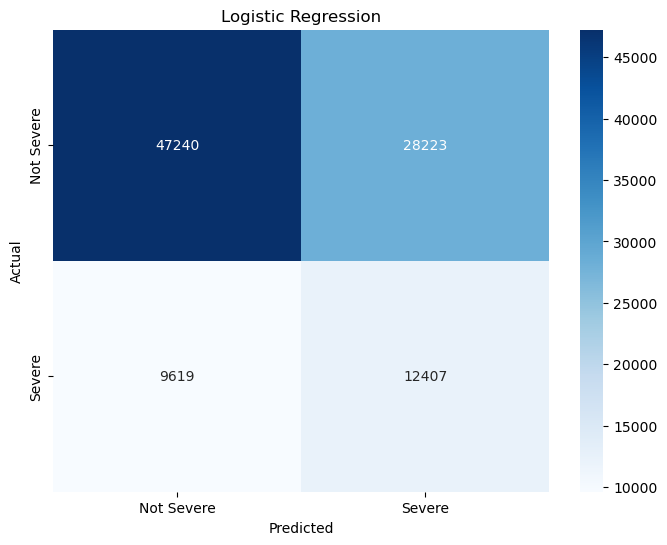

In [46]:
# Confusion Matrix for Logistic Regression - Cleaned
logistic_cm = confusion_matrix(y_test_f, y_pred_f)

logistic_cm = confusion_matrix(y_test_f, y_pred_f)

# plotly refused to cooperate
plt.figure(figsize=(8, 6))
sns.heatmap(logistic_cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Not Severe', 'Severe'],
            yticklabels=['Not Severe', 'Severe'])
plt.title('Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Model Comparison 

# model names
models = list(model_results.keys())

# ROC curves
fpr_log, tpr_log, _ = roc_curve(y_test_nc, y_pred_proba_nc)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test_ncrf, y_pred_rfnc_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

roc_fig = go.Figure()

# Logistic Regression curve
roc_fig.add_trace(
    go.Scatter(
        x=fpr_log, y=tpr_log,
        mode='lines',
        name=f'Logistic Regression (AUC = {roc_auc_log:.3f})',
        line=dict(color='blue', width=3)
    )
)

# d Random Forest curve
roc_fig.add_trace(
    go.Scatter(
        x=fpr_rf, y=tpr_rf,
        mode='lines',
        name=f'Random Forest (AUC = {roc_auc_rf:.3f})',
        line=dict(color='orange', width=3)
    )
)

# random guess line
roc_fig.add_trace(
    go.Scatter(
        x=[0, 1], y=[0, 1],
        mode='lines',
        name='Random Guess',
        line=dict(color='red', width=2, dash='dash'),
        opacity=0.7
    )
)

roc_fig.update_layout(
    title='ROC Curves - Models without Company Variables',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    template='plotly_white',
    height=600,
    width=800,
    showlegend=True,
    legend=dict(
        x=0.6,
        y=0.2,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='rgba(0,0,0,0.2)',
        borderwidth=1
    )
)

# Add grid
roc_fig.update_xaxes(showgrid=True, gridcolor='rgba(0,0,0,0.1)')
roc_fig.update_yaxes(showgrid=True, gridcolor='rgba(0,0,0,0.1)')

roc_fig.show()

# Conclusions

The balanced approach to creating numeric scoring for RoBERTa and DistilBERT pipelines effectively labeled consumer complaint narratives, and the resulting sentiment and severity columns provide significant value for financial institutions looking to quickly filter consumer complaint data. While the severity scoring proved effective for quickly identifying consumer complaints for high priority triage, predicting severity from product and issue categories alone proved insufficient, suggesting that there is critical information not captured by these categorical variables. <br>

Financial institutions need more than publicly available CFPB variables to predict high-severity complaints effectively. However, one actionable insight emerged: complaints with consumer narratives deserve priority review. Although only 37.7% of complaints included narratives, all major banks in this study showed narrative rates above 50%. This suggests that when customers invest time writing detailed narratives, severity is likely higher.<br>

The persistent impact of institutional misconduct is evident in the data. Wells Fargo, the institution involved in the 2016 cross-selling scandal (Noel and Osman, 2024), continues to have the highest count of consumer complaints across the banking industry seven years later, illustrating the lasting reputational damage from failed customer trust.<br>

**Sources**

Noel, M. D., & Osman, S. M. I. (2024). Bank scandal contagion: Evidence from the Wells Fargo cross-selling scandal. Global Finance Journal, 63, 101044.


In [ ]:
banks = [
    "WELLS FARGO & COMPANY",
    "JPMORGAN CHASE & CO.",
    "BANK OF AMERICA, NATIONAL ASSOCIATION",
    "CITIBANK, N.A.",
    "U.S. BANCORP",
    "TRUIST FINANCIAL CORPORATION",
    "TD BANK US HOLDING COMPANY",
    "GOLDMAN SACHS BANK USA",
    "BARCLAYS BANK DELAWARE",
    "SANTANDER HOLDINGS USA, INC.",
    "PNC Bank N.A.",
    "CITIZENS FINANCIAL GROUP, INC.",
    "DISCOVER BANK",
    "CAPITAL ONE FINANCIAL CORPORATION",
    "SYNCHRONY FINANCIAL",
    "AMERICAN EXPRESS COMPANY",
    "ALLY FINANCIAL INC.",
    "NAVY FEDERAL CREDIT UNION"
]
# Filtering for bank-related complaints
bank_complaints = consumer_ML_clean[consumer_ML_clean['Company'].isin(banks)]
# counting the number of bank_complaints vs total complaints
print(f"Bank-related complaints: {len(bank_complaints):,} out of {len(consumer_ML_clean):,} total complaints")
#calculating percent
bank_percent = (len(bank_complaints)/len(consumer_ML_clean))*100
print(f"Percent of bank-related consumer complaints: {bank_percent:.2f}")


Bank-related complaints: 67,424 out of 487,445 total complaints
Percent of bank-related consumer complaints: 13.83


In [ ]:
#getting total complaints from original dataset
total_bank_complaints = consumer[consumer['Company'].isin(banks)].groupby('Company').size().reset_index(name='total_complaints')

# complaints with narratives from consumer_full_bert
narrative_bank_complaints = consumer_full_bert[consumer_full_bert['Company'].isin(banks)].groupby('Company').agg(
    complaint_count=('Company', 'size'),
    avg_severity=('severity_score', 'mean')
).reset_index()

# merging the data
bank_comparison = total_bank_complaints.merge(
    narrative_bank_complaints, 
    left_on='Company', 
    right_on='Company', 
    how='inner'
)

# percentage with narratives
bank_comparison['percent_narrative'] = (bank_comparison['complaint_count'] / bank_comparison['total_complaints']) * 100

# top 10 banks by total complaints
top_10_comparison = bank_comparison.sort_values('total_complaints', ascending=False).head(10)
sorted_data = top_10_comparison.sort_values('total_complaints', ascending=True)

# grouped bar chart
bank_fig = go.Figure()

# total complaints bars
bank_fig.add_trace(
    go.Bar(
        y=sorted_data['Company'],
        x=sorted_data['total_complaints'],
        name='Total Complaints',
        marker_color='#addc91',
        orientation='h',
        text=[f"{count:,}" for count in sorted_data['total_complaints']],
        textposition='inside',
        textfont=dict(size=10),
        offsetgroup=1
    )
)

# complaints with narratives bars
bank_fig.add_trace(
    go.Bar(
        y=sorted_data['Company'],
        x=sorted_data['complaint_count'],
        name='With Narratives',
        marker_color='#2cb34a',
        orientation='h',
        text=[f"{count:,}" for count in sorted_data['complaint_count']],
        textposition='inside',
        textfont=dict(size=12, color='white'),
        offsetgroup=2
    )
)

bank_fig.update_layout(
    title={
        'text': 'Top 10 Banks: Total Complaints vs Complaints with Consumer Narratives',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    xaxis_title='Number of Complaints',
    yaxis_title='Bank',
    template='plotly_white',
    height=800,
    width=1200,
    barmode='group',
    legend=dict(
        font=dict(size=14),
        orientation="h",
        yanchor="top",
        y=1.05,
        xanchor="center",
        x=0.4
    ),
    margin=dict(l=250, r=50, t=100, b=50)   
)
bank_fig.update_traces(textfont=dict(size=14))

bank_fig.show()

# comparison table
top_10_comparison

Company  total_complaints  complaint_count  \
17                  WELLS FARGO & COMPANY             20722            11322   
4       CAPITAL ONE FINANCIAL CORPORATION             17019             8712   
9                    JPMORGAN CHASE & CO.             15615             8332   
2   BANK OF AMERICA, NATIONAL ASSOCIATION             14315             7721   
5                          CITIBANK, N.A.              9796             5313   
13                    SYNCHRONY FINANCIAL              7095             3979   
1                AMERICAN EXPRESS COMPANY              6116             3253   
7                           DISCOVER BANK              5211             2543   
10              NAVY FEDERAL CREDIT UNION              4335             1978   
16                           U.S. BANCORP              4183             2359   

    avg_severity  percent_narrative  
17      0.493998          54.637583  
4       0.475643          51.189847  
9       0.479779          53.358950  
2       0.506261          53.936430  
5       0.478921          54.236423  
13      0.472162          56.081748  
1       0.473825          53.188358  
7       0.502617          48.800614  
10      0.505751          45.628604  
16      0.483658          56.394932

In [4]:
# Show 10 consumer narratives with severity scores below .3, display full narrative and severity score
pd.set_option('display.max_colwidth', None)
low_severity_narratives = consumer_full_bert[consumer_full_bert['severity_score'] < 0.3][['Consumer complaint narrative', 'severity_score']].head(10)
low_severity_narratives.style.format({'severity_score': '{:.3f}'})
low_severity_narratives

Consumer complaint narrative  \
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       I cancelled my auto debit along with putting my account into forbearance on XX/XX/2023. I received confirmation that night that my auto debit was cancelled, and no pending payments for the auto-debit were active.\n\nOn XX/XX/23 I received notification from my bank that the auto-debit was taken out of my account, causing me to go negative on hand. \n\nI call nelnet and they show no pending payments for the auto-debit. Then they back tracked and said you needed to cancel it 3 business days prior. I checked all the documentation provided while cancelling including the cancellation email, and none of the paperwork mentioned any of this.   
11                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            I have paid and contacted the company to get the account removed. They said they reported it already and that's all they can do. I asked to provide documentation that they did that so I could send to the bureaus and they did, I sent it and no change.   
26                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [11]:
# calculate percent of high severity complaints in the bert dataset
high_severity_count = (consumer_full_bert['severity_score'] >= 0.7).sum()
total_count = len(consumer_full_bert)

high_severity_percent = (high_severity_count / total_count) * 100
high_severity_percent


np.float64(22.593523371867597)